# U2 - Abdullah Barhoum (5041774) und Katharina Müller (5284090)

# Assignment 2: Convolution and Canny edge detection

## Exercise 2.1
Implement the convolution operation for 2-D images (i.e. no colors here, sorry). 

Convolve an image of your choice with a Gaussian kernel. Play around with the size of the kernel and the standard deviation of the Gaussian. Show your results (***RESULT***). 

In [1]:
#%matplotlib inline 
from skimage import io, color, filters
from matplotlib import pyplot as plt
from copy import copy, deepcopy
import numpy as np
import cv2
from math import ceil, floor
import sys

"""
def conv2d(image, kernel):
    h, w = image.shape
    image = image.reshape(h * w)
    
    def get_pix(x):
        print(x)
        return 0 if x < 0 or x >= image.shape[0] else image[x]
    
    k,_ = kernel.shape
    k2 = int(floor(k/2))
    
    for i in range(h * w):
        start_point = i - k2 - (k2 * w)
        values = np.zeros(k * k)
        current = start_point
        for j in range(k):
            indices = range(start_point, start_point + k)
            values[j: j + k] = list(map(get_pix,indices ))
            print(values[j: j + k])
            start_point += w
        print(values.reshape(k, k))
        raise
        
    return result
"""

def conv2d(image, kernel, show=False):
    image_h, image_w = image.shape
    kernel_h, kernel_w = kernel.shape
    result = np.zeros(image.shape)
    pad_h = int((kernel_h - 1) / 2)
    pad_w = int((kernel_w - 1) / 2)
    padded = np.zeros((image_h + (2 * pad_h), image_w + (2 * pad_w)))
    padded[pad_h:padded.shape[0] - pad_h, pad_w:padded.shape[1] - pad_w] = image

    for row in range(image_h):
        for col in range(image_w):
            result[row, col] = np.sum(
                kernel * padded[row:row + kernel_h, col:col + kernel_w])
    return result

image = color.rgb2gray(io.imread('images/dog.jpg'))

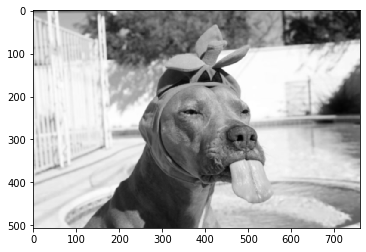

In [2]:
#default Gaussian
plt.imshow(filters.gaussian(image), cmap='gray')

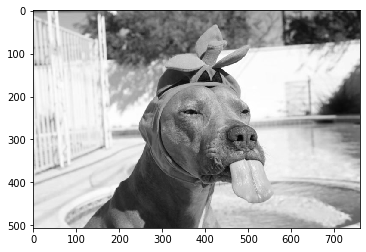

In [3]:
#small SD => less smoothing/blurring
plt.imshow(filters.gaussian(image, sigma=0.4), cmap='gray')

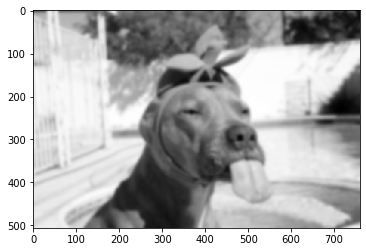

In [4]:
#large SD => more smoothing/blurring
plt.imshow(filters.gaussian(image, sigma=3), cmap='gray')

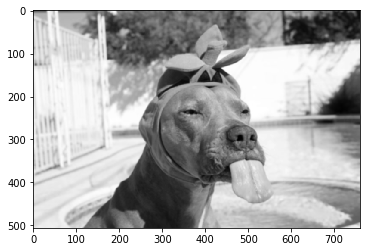

In [5]:
blur = cv2.GaussianBlur(image, (5, 5), 0)
plt.imshow(blur, cmap='gray')

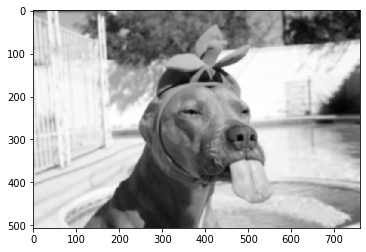

In [6]:
#big kernel => more blur
blur_2 = cv2.GaussianBlur(image,(9,9),0)
plt.imshow(blur_2, cmap='gray')

Now, implement a simple edge detector by first filtering with a Sobel operator and then thresholding the ***RESULT***. How does smoothing the input change the ***RESULT***?

In [7]:
G_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 2]
])
G_y = np.array([
    [ 1,  2,  1],
    [ 0,  0,  0],
    [-1, -2, -1]
])

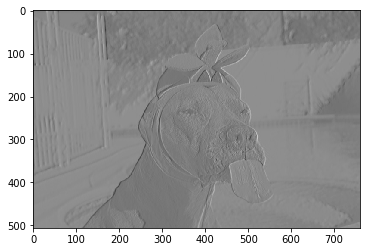

In [8]:
result_x = conv2d(image, G_x)
plt.imshow(result_x, cmap='gray')
plt.show()

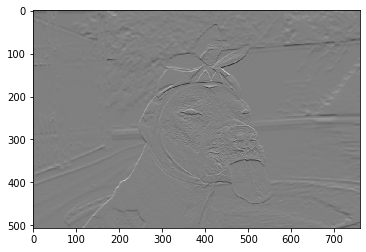

In [9]:
result_y = conv2d(image, G_y)
plt.imshow(result_y, cmap='gray')
plt.show()

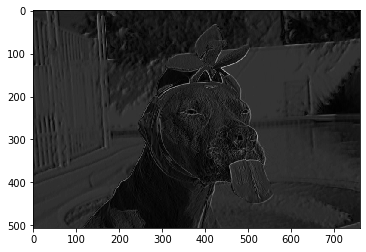

In [10]:
both = np.sqrt(np.square(result_x) + np.square(result_y))
both *= 255.0 / both.max()

plt.imshow(both, cmap='gray')
plt.show()

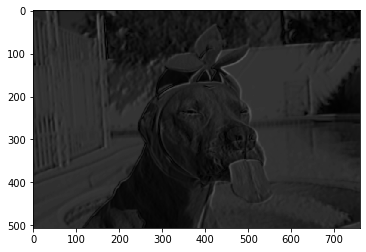

In [11]:
#more smoothing results in less clear edges
result_x_blur = conv2d(blur_2, G_x, True)
result_y_blur = conv2d(blur_2, G_y, True)
both_blur = np.sqrt(np.square(result_x_blur) + np.square(result_y_blur))
both_blur *= 255 / both_blur.max()
plt.imshow(both_blur, cmap='gray')
plt.show()

In [12]:
#Thresholding
def threshholding_function (image, threshold):
    image_h, image_w = image.shape
    plt.imshow(image, cmap='gray')
    plt.show()
    result = np.zeros(image.shape)
    for row in range(image_h):
        for col in range(image_w):
            if image[row,col] > threshold:
                result[row,col] = 255
            else:
                result[row,col] = 0
    return result

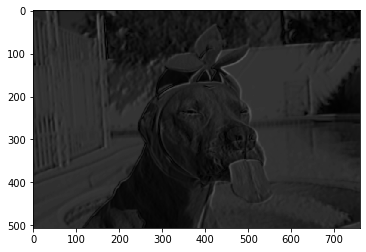

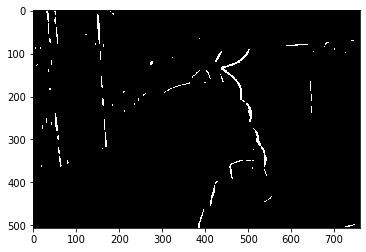

In [13]:
plt.imshow(threshholding_function(both_blur, 60), cmap='gray')
plt.show()

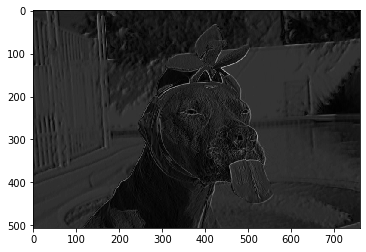

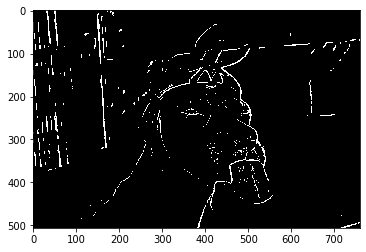

In [14]:
plt.imshow(threshholding_function(both, 60), cmap='gray')
plt.show()

## Exercise 1.2 Canny Edge Detection

### Preprocessing
If you haven't yet: smooth the image with a Gaussian of your choice. Then use the Sobel operator to create the gradient magnitude and direction matrices (see slides page 23). Round the gradient directions to the 8-neighbor's directions. Display all  intermediate ***RESULT***s!


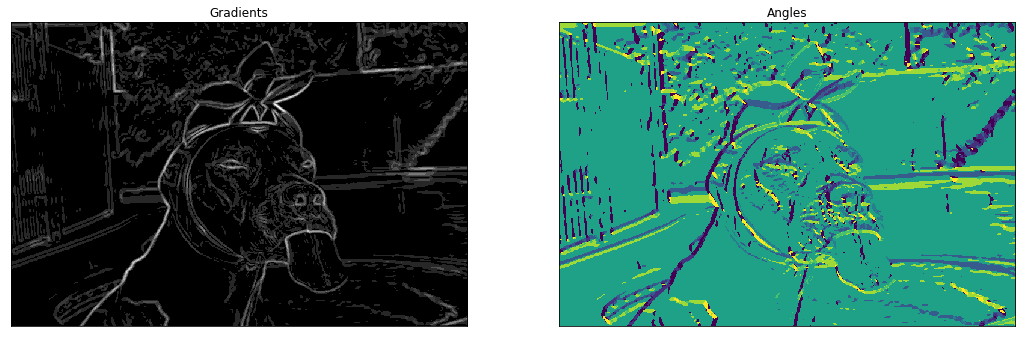

In [34]:
def canny_preprocessing(image):
    blur_kernel_size = 7
    blur = cv2.GaussianBlur(image, (blur_kernel_size, blur_kernel_size), 0)
    # opencv docs recommend using Scharr instead of Sobel
    # https://docs.opencv.org/3.4/d2/d2c/tutorial_sobel_derivatives.html
    filter2d = cv2.Scharr # Sobel or Scharr
    g_x = filter2d(blur, cv2.CV_16S, 1, 0)
    g_y = filter2d(blur, cv2.CV_16S, 0, 1)
    g = np.sqrt(g_x * g_x + g_y * g_y)
    angles = np.arctan2(g_y, g_x)
    pi2 = np.pi * 2
    angles = (angles + np.pi) % pi2 # convert values in range (-pi, pi) to (0, 2pi)
    # print(np.unique(angles))
    angles = np.floor(angles / pi2 * 8) # convert values in range (0, 2pi) to (0, 7)
    return g, angles.astype(np.int32)

gradients, angles = canny_preprocessing(image)
plt.figure(figsize=(18,8))
plt.subplot(121),plt.imshow(gradients, cmap='gray'),plt.title('Gradients'),plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(angles, vmin=0, vmax=7),plt.title('Angles'),plt.xticks([]), plt.yticks([])
plt.show()

In [16]:
def full_screen(img, **kwargs):
    plt.figure(figsize=(16,10))
    plt.imshow(img, **kwargs)
    plt.show()

### Non-Maximum Suppression
Implement the Non-Maximum Suppression step as described in the lecture. Subtract the result from the gradient magnitude image and show the ***RESULT***!

In [29]:
def edge_thinning(gradients_org, angles):
    gradients = np.copy(gradients_org)
    angle_to_offset = {
        # counter-clock wise, from unit-circle zero
        0: ( 0,  1),  # (y_offset, x_offset)
        1: (-1,  1),
        2: (-1,  0),
        3: (-1, -1),
        4: ( 0, -1),
        5: ( 1, -1),
        6: ( 1,  0),
        7: ( 1,  1)
    }
    
    H, W = gradients.shape
    def grad_at_pix(y, x):
        if y < 0 or y >= H or x < 0 or x >= W:
            return None
        return gradients[y, x]
    
    for y, col in enumerate(angles):
        for x, angle in enumerate(col):
            grad = gradients[y, x]
            y_offset, x_offset = angle_to_offset[angle]
            next_grad = grad_at_pix(y + y_offset, x + x_offset)
            if next_grad is not None and grad <= next_grad:
                gradients[y, x] = 0
    return gradients_org - gradients

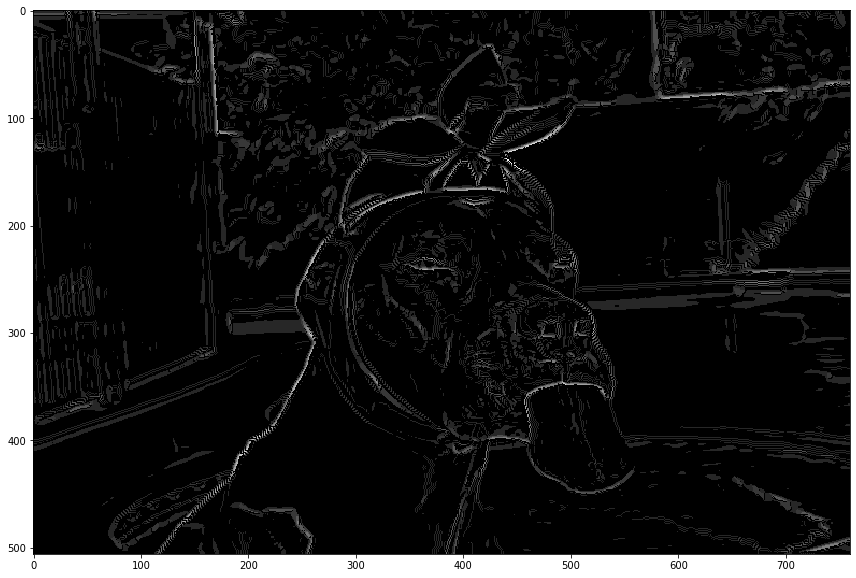

In [35]:
thinned = edge_thinning(gradients, angles)
full_screen(thinned, cmap='gray')

### Thresholding and Edge Tracing
Implement the edge tracing as described in the lecture and show the final result for three different threshold pairs: two low thresholds (e.g. 20 and 50), high thresholds (e.g. 80 and 120) and thresholds with large spacing (e.g. 40 and 140). (***RESULT***)


[0.        1.        1.4142135 2.        2.236068  2.828427  3.
 3.1622777 3.6055512 4.        4.1231055 4.2426405 4.472136  5.
 5.0990195 5.3851647 5.656854  5.8309517 6.4031243]


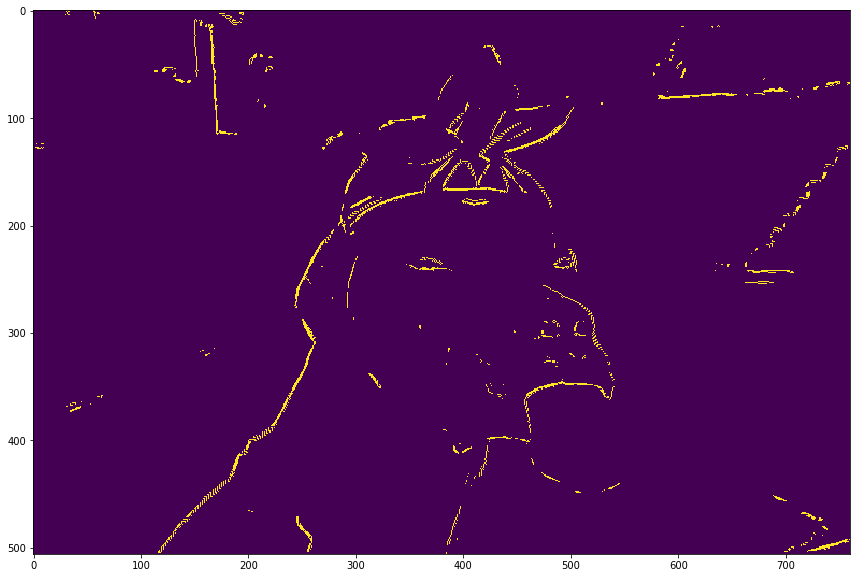

In [31]:
print(np.unique(thinned))
full_screen(thinned > 2)